### FDA Adverse Drug event analysis
- Data collected via https://open.fda.gov/data/faers/
- Data cleaned and aggregated via SingleDataFrame.ipynb
- Initial requests explored via Example of API Requests.ipynb

Authors:
John Bartlett
Kyle Walter
Assadour Derderian

       this first cell does not run as part of our analysis, it is just us testing limitations of the FDA API.

In [ ]:
# imports
import pandas as pd
import numpy as np
import json
import simplejson
from operator import itemgetter
import datetime
import requests
from flatten import flatten

# visualization imports
import matplotlib.pyplot as plt

# basic request / pull 1000 records from public api place in a data frame
testurl = 'https://api.fda.gov/drug/event.json?api_key=Tdpd5uUfE3AE6732OwcYkLsm8orfs72kehAz0nRA&limit=1000&search=patient.drug.medicinalproduct.exact:ADVIL'
data = requests.get(testurl).json()
data_dict = data['results']

# create DF
df = pd.json_normalize(data_dict, max_level=None, errors='ignore')

# works
df.head(10)
df.info
# clean the example data frame from above

# remove ugly non usable data this is eiter redundant data or not usable for visualization or modeling
df = df.drop(columns=['reporttype', 'safetyreportversion', 'receivedateformat', 'transmissiondateformat',
                      'fulfillexpeditecriteria', 'receiptdateformat', 'duplicate', 'receivedate', 'transmissiondate',
                      'primarysource.reportercountry', 'reportduplicate.duplicatenumb', 'receiver.receivertype',
                      'receiver.receiverorganization', 'sender.sendertype', 'sender.senderorganization',
                      'patient.summary.narrativeincludeclinical', 'primarysource.literaturereference'])

# these columns will be dropped because the resulting data will be normalized into 2 additional data frames
df = df.drop(columns=['patient.reaction', 'patient.drug'])
# works
df.head(10)
df.info

# now we need to expand 2 of the embedded json columns. normalize / flatten
# patient.reaction and patient.drug
# there is a lot of embedded lists / dictionaries in this json
# data_dict = data['results'] is a list of dictionaries
# create a meta data frame on reaction info

# we will need to use the columns from our previous dataframe as the meta for normalizing the resulting dfs
meta = list(df.columns)
# remove the dictionary entries that are lists or dictionaries
# found this out with trial and error
# this is too messy, we can just join resulting data frames

# create a meta dataframe on reaction info
df2 = pd.json_normalize(data=data_dict, record_path=['patient', 'reaction'], meta=meta,
                        max_level=None, errors='ignore')

df2.head(10)
df2.info
# create a meta dataframe on drug info
df3 = pd.json_normalize(data=data_dict, record_path=['patient', 'drug'], meta=['safetyreportid'],
                        max_level=None, errors='ignore')

# drug info needs cleanup
df3 = df3.drop(columns=['drugcharacterization', 'drugbatchnumb', 'drugauthorizationnumb',
                        'drugstartdateformat', 'drugstartdate', 'drugenddateformat',
                        'drugenddate', 'actiondrug', 'openfda.brand_name', 'openfda.generic_name',
                        'openfda.manufacturer_name', 'openfda.product_ndc', 'openfda.product_type',
                        'openfda.rxcui', 'openfda.spl_id', 'openfda.spl_set_id',
                        'openfda.package_ndc', 'openfda.route', 'openfda.substance_name',
                        'openfda.unii', 'openfda.nui', 'openfda.pharm_class_moa',
                        'openfda.pharm_class_cs', 'openfda.pharm_class_epc', 'openfda.application_number',
                        'drugcumulativedosagenumb', 'drugcumulativedosageunit', 'drugdosagetext',
                        'drugadministrationroute', 'activesubstance.activesubstancename',
                        'openfda.pharm_class_pe', 'drugrecurreadministration', 'drugadditional'])
df3.head(10)
df3.info
# now it's time to combine the resulting dataframes based on primary keys.



After API testing, we determined that API will not cut it.  We need to scale up for more data.
Below is code to pull the data in the json files directly off the api and save them out for further use.  Unrestricted use.

In [ ]:
# Calls in the packages used for the downloading of information from
# Open FDA's website
import wget
import requests

URL = 'https://api.fda.gov/download.json'  #list of all the FDA Files

#Link to where I want the data saved
Savelocation = 'J:\My Drive\Graduate School\IST718 Big Data Analysis\Final Project\Files'
# Calls the downloads list as a JSON and formats the data as a string
downloads = requests.get(URL).json()
drug_events = downloads.get('results', {}).get('drug', {}).get('event', {}).get('partitions', [])

# Pulls the file path the JSON String and downloads the file
# Zip files are renamed at download appending the quarter
# This is done to not allow the data to be overwritten by files with the same name
for event in drug_events:
       zip_url = event.get('file', None)
       nmbr = zip_url.rfind('/')
       wget.download(zip_url, zip_url[41:nmbr] + '-' + zip_url[nmbr + 1:])
# Import OS Package and Zip File package
# They will be used to unzip the downloaded JSON Files
import os, zipfile

# This block loops through the zipped files, collects the file name
# The file is then renamed to the zip folder
# Note this works because there is only 1 JSON file in each compressed Fold
# The file is then unzip into a side directory
for item in os.listdir(r'J:\My Drive\Graduate School\IST718 Big Data Analysis\Final Project\Files'):
       if item.endswith(".zip"):
              file_name = os.path.abspath(item)
              zip_ref = zipfile.ZipFile(file_name)
              zip_info = zip_ref.infolist()
              for info in zip_info:
                     info.filename = file_name[file_name.rfind('\\') + 1:file_name.rfind('.zip')]
                     zip_ref.extract(info,
                                     path=r'J:\My Drive\Graduate School\IST718 Big Data Analysis\Final Project\Unzipped Files')

Once the above code runs. IT TAKES HOURS / DAYS.
We then combined the files to one convient CSV file with the below code.

*** note we do not run this each time we do a data load, we only run these initial blocks ONCE.

In [ ]:
import os
import pandas as pd
import json

os.chdir(r'J:\My Drive\Graduate School\IST718 Big Data Analysis\Final Project\Unzipped Files\Starter File')
#Lists for Sub Frames
medicines = []
reactions = []

#The loop to end all loops
path = os.getcwd()
for subdir, dirs, files in os.walk(path):
    for f in files:
        if f.endswith('.json'):
            with open(os.path.join(subdir, f)) as data_file:
                d = json.load(data_file)
                df = pd.json_normalize(d['results'], max_level=None)
                del data_file
                del d
                #Flatten Additional Columns
                df['patient.reaction'] = df['patient.reaction'].apply(lambda x: pd.json_normalize(x))
                df['patient.drug'] = df['patient.drug'].apply(lambda x: pd.json_normalize(x))
                df = df.drop(
                    columns=['reporttype', 'safetyreportversion', 'receivedateformat', 'transmissiondateformat',
                             'fulfillexpeditecriteria', 'receiptdateformat', 'duplicate', 'receivedate',
                             'transmissiondate',
                             'primarysource.reportercountry', 'reportduplicate.duplicatenumb', 'receiver.receivertype',
                             'receiver.receiverorganization', 'sender.sendertype', 'sender.senderorganization',
                             'patient.summary.narrativeincludeclinical', 'primarysource.literaturereference'])
                df = df[(df['primarysource.qualification'] == '3') | (df['primarysource.qualification'] == '2') | (
                            df['primarysource.qualification'] == '1')].reset_index()

                #Collect the Medicines
                for i in range(0, len(df['safetyreportid'])):
                    report = pd.DataFrame(df['patient.drug'][i])
                    for l in range(0, len(report['medicinalproduct'])):
                        d = {'safetyreportid': df['safetyreportid'][i],
                             'medicinalproduct': report['medicinalproduct'][l]}
                        medicines.append(d)

                #Collect the Reactions
                for i in range(0, len(df['safetyreportid'])):
                    report = pd.DataFrame(df['patient.reaction'][i])
                    for l in range(0, len(report['reactionmeddrapt'])):
                        d = {'safetyreportid': df['safetyreportid'][i],
                             'reactionmedrapt': report['reactionmeddrapt'][l]}
                        reactions.append(d)
                mDf = df.drop(columns=['patient.drug', 'patient.reaction'])
                try:
                    masterDF = masterDF.append(mDf, ignore_index=True)
                except:
                    masterDF = mDf
                    print("masterDF didn't exist")  #should see 1 time
                del d
                del df
os.chdir(r'J:\My Drive\Graduate School\IST718 Big Data Analysis\Final Project\flattenedOutput')

masterDF.to_pickle('consolidatedData.pkl')
masterDF.to_csv('consolidatedData.csv')
del masterDF
reactions = pd.DataFrame(reactions)
reactions.to_pickle('reactions.pkl')
reactions.to_csv('reaction.csv')
del reactions
medicines = pd.DataFrame(medicines)
medicines.to_pickle('medicines.pkl')
medicines.to_csv('medicines.csv')
del medicines

### FDA Adverse Drug event analysis
- Data collected via https://open.fda.gov/data/faers/
- Data cleaned and aggregated via SingleDataFrame.ipynb
- Initial requests explored via Example of API Requests.ipynb

In [1]:
# FDA adverse drug events analysis

# imports
import pandas as pd
import numpy as np
import json
from operator import itemgetter
import datetime as datetime
import requests
import dask.dataframe as dd

#sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# visualization imports
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


## Initial Data Load

In [2]:
# read in consolidated df created in

pathToData = 'J:\My Drive\Graduate School\IST718 Big Data Analysis\Final Project\consolidatedData.csv'
df_fda = pd.read_csv(pathToData,dtype={'authoritynumb': 'object',
       'patient.patientagegroup': 'float64',
       'patient.patientonsetage': 'float64',
       'patient.patientonsetageunit': 'float64',
       'patient.patientsex': 'float64',
       'seriousnesshospitalization': 'float64',
       'safetyreportid': 'object',
       'medicinalproduct':'object',
        'reactionmedrapt':'object'})

# df_fda=df_fda.compute()

Above is the time required to load data into python env via the CSV file we created earlier.

Below is code we used through analysis to create samples to more easily view the data during cleanup

In [3]:
# check a sample of the data works
sample = df_fda.sample(1000)
sample.info
# identify columns to drop

<bound method DataFrame.info of               V1  index safetyreportid  serious  receiptdate  \
39940820  202987  11186       12868930        1     20200213   
53335615   40568   2866       18434845        1     20201028   
53995427    2760    410       18454171        1     20201102   
4028764    60700   4760       12487163        1     20160712   
47840759   58096   2297       17282843        1     20200719   
...          ...    ...            ...      ...          ...   
34829344  158518   8974       16627498        1     20190724   
14378867   21392   8972       14139211        1     20171028   
55230255  196022   9554       18468492        1     20201105   
46672768  133896   6405       17884094        1     20200611   
14712395   33050   4329       14300098        1     20171219   

                             companynumb occurcountry  \
39940820        US-PFIZER INC-2016485522           US   
53335615  CA-CELLTRION INC.-2020CA029502           CA   
53995427           CA-JNJFOC

## Begin Filtering and cleanup here

In [4]:
%%time

df_fda = df_fda.drop(columns = ['authoritynumb', 'companynumb','reportduplicate.duplicatesource',
                                'patient.patientonsetageunit','patient.patientagegroup','primarysourcecountry','V1','index', 'receiver'])

# filter out all 2 and 3's from primarysource.qualification
# df_fda = df_fda[df_fda.primarysource.qualification != 1]

# drop health professionals
#df_fda = df_fda.drop(columns = 'primarysource.qualification')

# replace nan ages with -1
df_fda['patient.patientonsetage'] = df_fda['patient.patientonsetage'].fillna(-1)
# filter ages drop every age over 115 (probably reporting anomalies)
df_fda = df_fda.loc[df_fda['patient.patientonsetage'] < 115]
# convert ages to ints
df_fda['patient.patientonsetage'] = df_fda['patient.patientonsetage'].astype(int)

# replace nan weights with -1
df_fda['patient.patientweight'] = df_fda['patient.patientweight'].fillna(-1)
# filter weights drop every weight over 635kg (the heaviest man ever) (probably reporting anomalies)
df_fda = df_fda.loc[df_fda['patient.patientweight'] < 635]
# converting to int where floats aren't needed
df_fda['patient.patientweight'] = df_fda['patient.patientweight'].astype(int)

# replace nan sex with -1
df_fda['patient.patientsex'] = df_fda['patient.patientsex'].fillna(-1)
# converting to int where floats aren't needed
df_fda['patient.patientsex'] = df_fda['patient.patientsex'].astype(int)

# convert potential bool values
# fill nan with 0
# big caveat with these conversions FALSE could indicate UNREPORTED data not just FALSE
df_fda[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
       'seriousnesscongenitalanomali', 'seriousnessdisabling']] = \
       df_fda[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
              'seriousnesscongenitalanomali', 'seriousnessdisabling']].fillna(0)

# convert 1/0 columns to bol
df_fda[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
       'seriousnesscongenitalanomali', 'seriousnessdisabling']] = \
       df_fda[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
              'seriousnesscongenitalanomali', 'seriousnessdisabling']].astype('bool')

# convert receipt date to datetime
df_fda['receiptdate'] = pd.to_datetime(df_fda['receiptdate'],format='%Y%m%d')
df_fda['receiptdate'] = df_fda['receiptdate'].dt.date


Wall time: 38.4 s


Data set is now 'clean' lets generate some summary statistics

In [5]:
df_fda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56104095 entries, 0 to 56282294
Data columns (total 16 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   safetyreportid                object
 1   serious                       int64 
 2   receiptdate                   object
 3   occurcountry                  object
 4   seriousnesshospitalization    bool  
 5   primarysource.qualification   int64 
 6   patient.patientonsetage       int32 
 7   patient.patientweight         int32 
 8   patient.patientsex            int32 
 9   seriousnessother              bool  
 10  seriousnesslifethreatening    bool  
 11  seriousnessdeath              bool  
 12  seriousnesscongenitalanomali  bool  
 13  seriousnessdisabling          bool  
 14  reactionmedrapt               object
 15  medicinalproduct              object
dtypes: bool(6), int32(3), int64(2), object(5)
memory usage: 4.3+ GB


In [6]:
# summarize age of patients
df_fda.loc[df_fda['patient.patientonsetage'] > 0]['patient.patientonsetage'].describe()


count    4.276881e+07
mean     5.662904e+01
std      1.940464e+01
min      1.000000e+00
25%      4.500000e+01
50%      6.000000e+01
75%      7.100000e+01
max      1.140000e+02
Name: patient.patientonsetage, dtype: float64

<AxesSubplot:title={'center':'Age Range Adverse Effects'}, ylabel='count'>

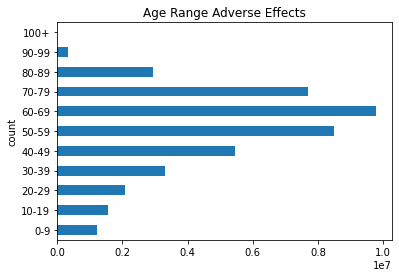

In [7]:
# create a summary column for age range
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80 ,90, 100, 115]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']
df_fda['agerange'] = pd.cut(df_fda['patient.patientonsetage'], bins, labels = labels,include_lowest = True)

# plot results
df_fda['agerange'].value_counts(sort=False).plot(kind = 'barh', title = 'Age Range Adverse Effects', ylabel = 'count')


In [8]:
# summarize sex of patients
df_fda.loc[df_fda['patient.patientsex'] > 0]['patient.patientsex'].describe()

count    5.064822e+07
mean     1.613110e+00
std      4.870381e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: patient.patientsex, dtype: float64

In [9]:
# summarize sex of patients
#df_fda.loc[df_fda['patient.patientsex'] > 0].boxplot(column='patient.patientsex')

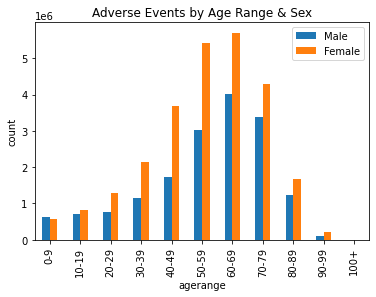

In [10]:
# plot sex vs age
fig, ax = plt.subplots()
df_fda.loc[df_fda['patient.patientsex'] > 0].groupby(['agerange','patient.patientsex']).size().unstack(level=1).plot(kind='bar', title = 'Adverse Events by Age Range & Sex', ylabel = 'count', ax = ax)
ax.legend(['Male', 'Female'])


In [11]:
# summarize weight of patients
df_fda.loc[df_fda['patient.patientweight'] > 0]['patient.patientweight'].describe()

count    2.087740e+07
mean     7.431710e+01
std      2.510824e+01
min      1.000000e+00
25%      5.900000e+01
50%      7.200000e+01
75%      8.800000e+01
max      6.180000e+02
Name: patient.patientweight, dtype: float64

<AxesSubplot:>

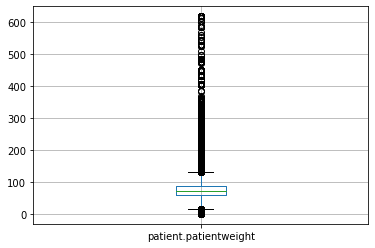

In [12]:
# bar plot weight distribution no real tell here, lots of outliers
df_fda.loc[df_fda['patient.patientweight'] > 0].boxplot(column='patient.patientweight')

In [13]:
# summary of primary source
df_fda['primarysource.qualification'].describe()


count    5.610410e+07
mean     2.041563e+00
std      9.515980e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.000000e+00
Name: primarysource.qualification, dtype: float64

An encoded value for the category of individual submitting the report.

1 = Physician
2 = Pharmacist
3 = Other Health Professional
We cut out the following codes:
4 = Lawyer
5 = Consumer or non-health professional

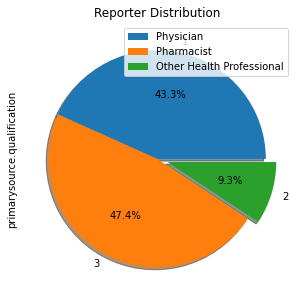

In [14]:
# plot primary source qualification distribution
fig, ax = plt.subplots()
df_fda['primarysource.qualification'].value_counts(sort=False).plot.pie(figsize=(5, 5), title = 'Reporter Distribution', ax = ax, autopct='%1.1f%%', explode=(0, 0, 0.1),shadow=True, startangle=0)
ax.legend(['Physician', 'Pharmacist', 'Other Health Professional'])

<AxesSubplot:title={'center':'Adverse Events Over Time (smoothed)'}, xlabel='receiptdate', ylabel='count'>

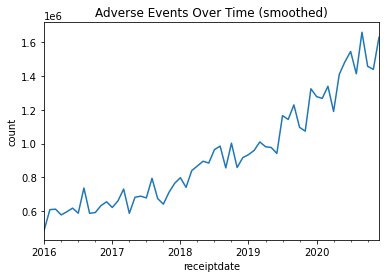

In [15]:
# time series plot to visualize seasonality
df_fda_time = df_fda
df_fda_time.index = pd.to_datetime(df_fda_time['receiptdate'])
#df_fda['receiptdate'].value_counts(sort=False).plot(kind = 'line', title = 'Adverse Events over time', ylabel = 'count')
df_fda_time['receiptdate'].resample('1M').count().plot(kind = 'line', title = 'Adverse Events Over Time (smoothed)', ylabel = 'count')


<AxesSubplot:title={'center':'Adverse Events over time'}, xlabel='receiptdate', ylabel='count'>

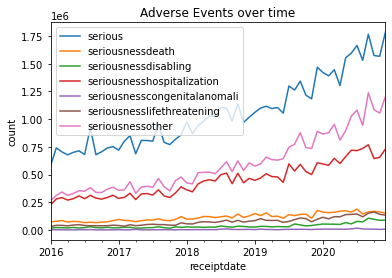

In [16]:
# subplots of total adverse events
df_fda_time[['receiptdate','serious','seriousnessdeath','seriousnessdisabling','seriousnesshospitalization','seriousnesscongenitalanomali','seriousnesslifethreatening','seriousnessother']].resample('1M').sum().plot(kind = 'line', title = 'Adverse Events over time', ylabel = 'count')


In [17]:
# drop any summary columns not usefule in modeling
# drop the summary column
df_fda = df_fda.drop(columns = 'agerange')
df_fda = df_fda.drop(columns = 'receiptdate')
df_fda_time = pd.DataFrame(None)
# df_fda = df_fda.reset_index()

### Modeling

In [18]:
# drop all negatives as these columns won't function in model appropriately
df_fda = df_fda.loc[df_fda['patient.patientweight'] > 0]
df_fda = df_fda.loc[df_fda['patient.patientonsetage'] > 0]
df_fda = df_fda.loc[df_fda['patient.patientsex'] > 0]

In [19]:
%%time
df_fda[[ 'seriousnesshospitalization','seriousnessother', 'seriousnesslifethreatening',
       'seriousnessdeath', 'seriousnesscongenitalanomali',
       'seriousnessdisabling','serious']].corr()

Wall time: 2.67 s


,seriousnesshospitalization,seriousnessother,seriousnesslifethreatening,seriousnessdeath,seriousnesscongenitalanomali,seriousnessdisabling,serious
seriousnesshospitalization,1.000000,-0.121247,0.115600,0.091915,-0.000870,-0.013904,-0.365558
seriousnessother,-0.121247,1.000000,0.035478,-0.014128,0.011361,0.040663,-0.386691
seriousnesslifethreatening,0.115600,0.035478,1.000000,0.167943,0.017849,0.108015,-0.107504
seriousnessdeath,0.091915,-0.014128,0.167943,1.000000,0.021687,-0.013392,-0.121042
seriousnesscongenitalanomali,-0.000870,0.011361,0.017849,0.021687,1.000000,0.026698,-0.018071
seriousnessdisabling,-0.013904,0.040663,0.108015,-0.013392,0.026698,1.000000,-0.072626
serious,-0.365558,-0.386691,-0.107504,-0.121042,-0.018071,-0.072626,1.000000


In [20]:
review = df_fda[[ 'seriousnesshospitalization','seriousnessother', 'seriousnesslifethreatening',
       'seriousnessdeath', 'seriousnesscongenitalanomali',
       'seriousnessdisabling','serious']]
review['serious'].value_counts()

1    16765423
2     1452069
Name: serious, dtype: int64

In [21]:
review[review['serious']==2]

,seriousnesshospitalization,seriousnessother,seriousnesslifethreatening,seriousnessdeath,seriousnesscongenitalanomali,seriousnessdisabling,serious
receiptdate,,,,,,,
2016-03-21,False,False,False,False,False,False,2
2016-03-21,False,False,False,False,False,False,2
2016-03-21,False,False,False,False,False,False,2
2016-03-04,False,False,False,False,False,False,2
2016-03-04,False,False,False,False,False,False,2
...,...,...,...,...,...,...,...
2020-10-01,False,False,False,False,False,False,2
2020-10-01,False,False,False,False,False,False,2
2020-11-11,False,False,False,False,False,False,2


# Creating a risk level category

The Data show many different types of possible seriousness levels. To help medical professionals make the best decision it it possible to predict the risk level outcome so they can discuss care options with their patients

For High Risk Death and Disablement were decided as these appear the most extreme outcomes for people, they can either no longer live their lives or are in a state where they are no longer alive

For Medium High Risk Hospitalization and lifethreatening reactions were tagged. While both of these events result in medical staff the patient is getting closer to the High Risk category in which their life will never be the same.

Medium risk was congential anamoli, more commonly known as birth defects. The data below shows these are super rarely reported and likely will preform poorly in the model without further data.

Medium low risk was classified with Seriousness other. As a number of the reactions are things like no reaction or off label use the impact is difficult to quantify, on one hand no effect maybe good, but if a medication is supposed to reduct blood presure it could be on the end of the spectrum. The expectation if the result is the more serious category the doctor would code the report in a higher category such as life threatening.

Low Risk = when the other categories are all false the seriousness category is 2 this represent a situation where the patient is in no known quantifyable danger with the current information provided.

In [22]:
df_fda.loc[df_fda['serious']==2,"RiskLevel"] = "Low Risk"
df_fda.loc[df_fda['seriousnessother']==True,'RiskLevel']="Medium Low Risk"
df_fda.loc[df_fda['seriousnesscongenitalanomali']==True,"RiskLevel"] = "Medium Risk"
df_fda.loc[(df_fda['seriousnesslifethreatening']==True)|(df_fda['seriousnesshospitalization']==True), 'RiskLevel'] = "Medium High"
df_fda.loc[(df_fda['seriousnessdeath']==True)|(df_fda['seriousnessdisabling']==True), "RiskLevel"]="High"

df_fda['RiskLevel'].value_counts()

Medium High        9010650
Medium Low Risk    4180876
High               3550209
Low Risk           1452069
Medium Risk          23688
Name: RiskLevel, dtype: int64

In [23]:
%%time
topReactions = df_fda['reactionmedrapt'].value_counts()

print("Total Number of Reaction Categories: ", len(topReactions))
print("average of the times reported: ",np.mean(topReactions))
print("High number of times reported: ", max(topReactions))
print("Lowest number of times reported: ", min(topReactions))

Total Number of Reaction Categories:  13851
average of the times reported:  1315.24741895892
High number of times reported:  256552
Lowest number of times reported:  1
Wall time: 948 ms


In [24]:
%%time

#list of most commonly reported reactions
topReactions = topReactions[:10]
topReactions = topReactions.index
topReactions = list(topReactions)
topReactions.append('Death')
topReactions

Wall time: 1.99 ms


['Diarrhoea',
 'Nausea',
 'Dyspnoea',
 'Fatigue',
 'Pyrexia',
 'Pneumonia',
 'Vomiting',
 'Headache',
 'Acute kidney injury',
 'Off label use',
 'Death']

In [25]:
# %%time
# #filter the list by topReactions
# df_fda = df_fda[df_fda['reactionmedrapt'].isin(topReactions)]
# df_fda.info()

In [26]:
df_fda.columns

Index(['safetyreportid', 'serious', 'occurcountry',
       'seriousnesshospitalization', 'primarysource.qualification',
       'patient.patientonsetage', 'patient.patientweight',
       'patient.patientsex', 'seriousnessother', 'seriousnesslifethreatening',
       'seriousnessdeath', 'seriousnesscongenitalanomali',
       'seriousnessdisabling', 'reactionmedrapt', 'medicinalproduct',
       'RiskLevel'],
      dtype='object')

In [27]:
topMeds = df_fda['medicinalproduct'].value_counts()
topMeds = topMeds[:500]
topMeds = topMeds.index
df_fda = df_fda[df_fda['medicinalproduct'].isin(topMeds)]
df_fda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11038223 entries, 2016-01-27 to 2020-11-25
Data columns (total 16 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   safetyreportid                object
 1   serious                       int64 
 2   occurcountry                  object
 3   seriousnesshospitalization    bool  
 4   primarysource.qualification   int64 
 5   patient.patientonsetage       int32 
 6   patient.patientweight         int32 
 7   patient.patientsex            int32 
 8   seriousnessother              bool  
 9   seriousnesslifethreatening    bool  
 10  seriousnessdeath              bool  
 11  seriousnesscongenitalanomali  bool  
 12  seriousnessdisabling          bool  
 13  reactionmedrapt               object
 14  medicinalproduct              object
 15  RiskLevel                     object
dtypes: bool(6), int32(3), int64(2), object(5)
memory usage: 863.2+ MB


In [28]:


#Create a variable to use a boolean for the medication used
df_fda['observation'] = 1

#transform to sparse matrix using a pivot table
df_fda = df_fda.pivot_table(index=['safetyreportid', 'serious', 'receiptdate', 'occurcountry',
       'seriousnesshospitalization', 'primarysource.qualification',
       'patient.patientonsetage', 'patient.patientweight',
       'patient.patientsex', 'seriousnessother', 'seriousnesslifethreatening',
       'seriousnessdeath', 'seriousnesscongenitalanomali',
       'seriousnessdisabling', 'reactionmedrapt', 'RiskLevel'], columns='medicinalproduct', values='observation', fill_value=0).reset_index()

In [29]:
# df_fda['reactionmedrapt'].value_counts(normalize=True)

In [30]:
df_fda['reactionmedrapt']=df_fda['reactionmedrapt'].astype("category") #convert ractions to category
df_fda['RiskLevel'] = df_fda['RiskLevel'].astype("category")

                 precision    recall  f1-score   support

           High    0.30264   0.28670   0.29446     96871
       Low Risk    0.36614   0.52762   0.43230     70590
    Medium High    0.54103   0.53833   0.53968    270675
Medium Low Risk    0.42393   0.35213   0.38471    151524
    Medium Risk    0.25660   0.45405   0.32790      1284

       accuracy                        0.44787    590944
      macro avg    0.37807   0.43177   0.39581    590944
   weighted avg    0.45042   0.44787   0.44646    590944



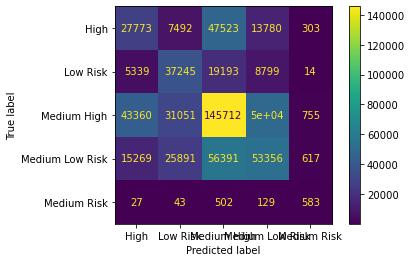

In [39]:
#create a model data frame from main data
modelData = df_fda.iloc[:,np.r_[15,6:9,16:516]]
#create Train and sample data sets
dfTrain, dfTest = train_test_split(modelData, test_size=.33, random_state=19, shuffle=True)

#Create training variables X represents independet variable and y the risk level being predicted
x_train = dfTrain.iloc[:,1:]
y_train = dfTrain.iloc[:,0]
x_test = dfTest.iloc[:,1:]
y_test = dfTest.iloc[:,0]

nb = MultinomialNB()

nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

# sns.heatmap(confusion_matrix(y_train,nb.predict(x_train)))
# print(classification_report(y_train,nb.predict(x_train), digits=5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=nb.classes_)
disp.plot()
print(classification_report(y_test, y_pred, digits=5))

                 precision    recall  f1-score   support

           High    0.95424   0.92118   0.93742     96871
       Low Risk    0.91252   0.87786   0.89485     70590
    Medium High    0.93108   0.96321   0.94688    270675
Medium Low Risk    0.93021   0.91001   0.92000    151524
    Medium Risk    0.89449   0.88474   0.88958      1284

       accuracy                        0.93232    590944
      macro avg    0.92451   0.91140   0.91775    590944
   weighted avg    0.93236   0.93232   0.93210    590944



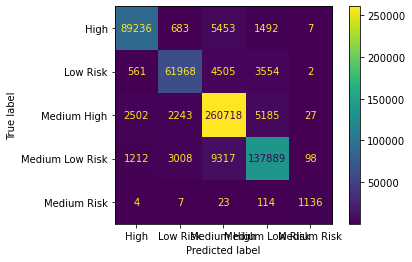

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

# sns.heatmap(confusion_matrix(y_train,rf_clf.predict(x_train),annot=True, xticklabels=True, yticklabels=True))
# print(classification_report(y_train,rf_clf.predict(x_train), digits=5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=nb.classes_)
disp.plot()
print(classification_report(y_test, y_pred, digits=5))

### Modeling 2

In [72]:
# reload and clean fresh copy of data
# claer existing DF for smoother load
df_fda_time = pd.DataFrame(None)

# read in consolidated df created in
t=time.time()

pathToData = 'X://consolidatedData.csv'

df_fda = dd.read_csv(pathToData,dtype={'authoritynumb': 'object',
       'patient.patientagegroup': 'float64',
       'patient.patientonsetage': 'float64',
       'patient.patientonsetageunit': 'float64',
       'patient.patientsex': 'float64',
       'seriousnesshospitalization': 'float64',
       'safetyreportid': 'object',
       'medicinalproduct':'object',
        'reactionmedrapt':'object'})

df_fda=df_fda.compute()

print("load train: " , str(datetime.timedelta(seconds=time.time()-t)))

load train:  0:01:20.913011


In [73]:
%%time

df_fda = df_fda.drop(columns = ['authoritynumb', 'companynumb','reportduplicate.duplicatesource',
                                'patient.patientonsetageunit','patient.patientagegroup','primarysourcecountry','V1','index', 'receiver'])

# filter out all 2 and 3's from primarysource.qualification
# df_fda = df_fda[df_fda.primarysource.qualification != 1]

# drop health professionals
#df_fda = df_fda.drop(columns = 'primarysource.qualification')

# replace nan ages with -1
df_fda['patient.patientonsetage'] = df_fda['patient.patientonsetage'].fillna(-1)
# filter ages drop every age over 115 (probably reporting anomalies)
df_fda = df_fda.loc[df_fda['patient.patientonsetage'] < 115]
# convert ages to ints
df_fda['patient.patientonsetage'] = df_fda['patient.patientonsetage'].astype(int)

# replace nan weights with -1
df_fda['patient.patientweight'] = df_fda['patient.patientweight'].fillna(-1)
# filter weights drop every weight over 635kg (the heaviest man ever) (probably reporting anomalies)
df_fda = df_fda.loc[df_fda['patient.patientweight'] < 635]
# converting to int where floats aren't needed
df_fda['patient.patientweight'] = df_fda['patient.patientweight'].astype(int)

# replace nan sex with -1
df_fda['patient.patientsex'] = df_fda['patient.patientsex'].fillna(-1)
# converting to int where floats aren't needed
df_fda['patient.patientsex'] = df_fda['patient.patientsex'].astype(int)

# convert potential bool values
# fill nan with 0
# big caveat with these conversions FALSE could indicate UNREPORTED data not just FALSE
df_fda[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
       'seriousnesscongenitalanomali', 'seriousnessdisabling']] = \
       df_fda[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
              'seriousnesscongenitalanomali', 'seriousnessdisabling']].fillna(0)

# convert 1/0 columns to bol
df_fda[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
       'seriousnesscongenitalanomali', 'seriousnessdisabling']] = \
       df_fda[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
              'seriousnesscongenitalanomali', 'seriousnessdisabling']].astype('bool')

# convert receipt date to datetime
df_fda['receiptdate'] = pd.to_datetime(df_fda['receiptdate'],format='%Y%m%d')
df_fda['receiptdate'] = df_fda['receiptdate'].dt.date

Wall time: 1min 8s


In [74]:
# drop some more data for this round of modeling

df_fda = df_fda.drop(columns = 'primarysource.qualification')
df_fda = df_fda.drop(columns = 'receiptdate')
df_fda = df_fda.drop(columns = 'safetyreportid')
df_fda = df_fda.drop(columns = 'reactionmedrapt')

# clean negatives
df_fda = df_fda.loc[df_fda['patient.patientweight'] > 0]
df_fda = df_fda.loc[df_fda['patient.patientonsetage'] > 0]
df_fda = df_fda.loc[df_fda['patient.patientsex'] > 0]

df_fda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18217492 entries, 0 to 207749
Data columns (total 12 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   serious                       int64 
 1   occurcountry                  object
 2   seriousnesshospitalization    bool  
 3   patient.patientonsetage       int32 
 4   patient.patientweight         int32 
 5   patient.patientsex            int32 
 6   seriousnessother              bool  
 7   seriousnesslifethreatening    bool  
 8   seriousnessdeath              bool  
 9   seriousnesscongenitalanomali  bool  
 10  seriousnessdisabling          bool  
 11  medicinalproduct              object
dtypes: bool(6), int32(3), int64(1), object(2)
memory usage: 868.7+ MB


In [75]:

df_fda.groupby(by='medicinalproduct')

sample = df_fda.sample(1000)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, REMODULIN to REMICADE
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   serious                       1000 non-null   int64 
 1   occurcountry                  998 non-null    object
 2   seriousnesshospitalization    1000 non-null   bool  
 3   patient.patientonsetage       1000 non-null   int32 
 4   patient.patientweight         1000 non-null   int32 
 5   patient.patientsex            1000 non-null   int32 
 6   seriousnessother              1000 non-null   bool  
 7   seriousnesslifethreatening    1000 non-null   bool  
 8   seriousnessdeath              1000 non-null   bool  
 9   seriousnesscongenitalanomali  1000 non-null   bool  
 10  seriousnessdisabling          1000 non-null   bool  
 11  medicinalproduct              1000 non-null   object
dtypes: bool(6), int32(3), int64(1), object(2)
memory usage: 48.8+ KB


In [71]:
sample.head()

,serious,occurcountry,seriousnesshospitalization,patient.patientonsetage,patient.patientweight,patient.patientsex,seriousnessother,seriousnesslifethreatening,seriousnessdeath,seriousnesscongenitalanomali,seriousnessdisabling,medicinalproduct
medicinalproduct,,,,,,,,,,,,
NIVOLUMAB,1,CN,True,53,-1,1,True,False,True,False,False,NIVOLUMAB
MANNITOL.,2,CN,False,43,-1,1,False,False,False,False,False,MANNITOL.
SODIUM CHLORIDE.,1,US,True,57,40,2,True,False,False,False,False,SODIUM CHLORIDE.
TOPAMAX,2,US,False,56,-1,2,False,False,False,False,False,TOPAMAX
SERTRALINE,1,DE,True,70,-1,2,True,False,False,False,False,SERTRALINE
